## Comparing [SPCI](https://arxiv.org/abs/2212.03463) with EnbPI

EnbPI
* Conference version: [ICML 2021](https://proceedings.mlr.press/v139/xu21h.html)
* Extended journal version: [IEEE TPAMI](https://ieeexplore.ieee.org/abstract/document/10121511)

In [2]:
# Uninstall everything related to the project to clear the conflict
!pip uninstall -y numpy scipy scikit-learn sklearn-quantile skranger statsmodels pandas

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-learn 1.7.2
Uninstalling scikit-learn-1.7.2:
  Successfully uninstalled scikit-learn-1.7.2
Found existing installation: sklearn_quantile 0.0.32
Uninstalling sklearn_quantile-0.0.32:
  Successfully uninstalled sklearn_quantile-0.0.32
Found existing installation: skranger 0.8.0
Uninstalling skranger-0.8.0:
  Successfully uninstalled skranger-0.8.0
Found existing installation: statsmodels 0.14.5
Uninstalling statsmodels-0.14.5:
  Successfully uninstalled statsmodels-0.14.5
Found existing installation: pandas 2.3.3
Uninstalling pandas-2.3.3:
  Successfully uninstalled pandas-2.3.3


In [3]:
# Reinstall with a strict ban on NumPy 2.0
!pip install "numpy<2.0" pandas scikit-learn sklearn-quantile skranger matplotlib scipy

  Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.3.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata (91 kB)
  Using cached scikit_learn-1.7.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (11 kB)
  Using cached sklearn_quantile-0.1.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.8 kB)
  Using cached skranger-0.8.0-cp310-cp310-macosx_10_15_x86_64.whl.metadata (8.1 kB)
  Using cached scipy-1.15.3-cp310-cp310-macosx_14_0_x86_64.whl.metadata (61 kB)
INFO: pip is looking at multiple versions of sklearn-quantile to determine which version is compatible with other requirements. This could take a while.
  Using cached sklearn_quantile-0.1.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.7 kB)
  Using cached sklearn_quantile-0.0.32-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.7 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl (20.6 MB)
Using cached pandas-2.3.3-cp310-cp310-macosx_10_9_x86_64.whl (11.6 MB)
Using cached scikit_l

In [4]:
# Correct spelling: statsmodels
%pip install statsmodels

  Using cached statsmodels-0.14.5-cp310-cp310-macosx_10_9_x86_64.whl.metadata (9.5 kB)
Using cached statsmodels-0.14.5-cp310-cp310-macosx_10_9_x86_64.whl (10.1 MB)
Note: you may need to restart the kernel to use updated packages.


### To use [EnbPI](https://arxiv.org/abs/2010.09107), which is fast

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For EnbPI, larger `past_window` will make intervals wider.

In [5]:
# Define or get data
from utils import data 
import torch
dloader = data.real_data_loader()
X_full, Y_full = dloader.electric_dataset()
X_full = torch.from_numpy(X_full)
Y_full = torch.from_numpy(Y_full)
print('Full data shape')
print(X_full.shape, Y_full.shape)
# Use 80% for training
train_frac = 0.8
N = int(X_full.shape[0] * train_frac)
X_train, X_predict, Y_train, Y_predict = X_full[:N], X_full[N:], Y_full[:N], Y_full[N:]
# Use past_window # past residuals to predict the next one. If there are not so many residuals, one can decrease it
past_window = 300 
print(f'We will thus construct {len(Y_predict)} prediction intervals during test time')

Full data shape
torch.Size([3444, 4]) torch.Size([3444])
We will thus construct 689 prediction intervals during test time


In [6]:
# Initialize the SPCI class
from sklearn.ensemble import RandomForestRegressor
import SPCI_class as SPCI
fit_func = RandomForestRegressor(n_estimators=10, max_depth=1, criterion='squared_error',
                                bootstrap=False, n_jobs=-1, random_state=1103)
EnbPI_class_  = SPCI.SPCI_and_EnbPI(X_train, X_predict, Y_train, Y_predict, fit_func=fit_func)
stride = 1
EnbPI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.9080090522766113 secs.


In [7]:
use_SPCI = False
smallT = not use_SPCI
EnbPI_class_.compute_PIs_Ensemble_online(
    alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI,
    quantile_regr=False, stride=stride)
results = EnbPI_class_.get_results(alpha, 'my_data', 1)

Shape of slided residual lists is (689, 300)
Finish Computing 689 UNIQUE Prediction Intervals, took 0.5510649681091309 secs.
Average Coverage is 0.9100145137880987
Average Width is 0.3231547572215845


Text(0.5, 1.0, 'EnbPI on Electricity Transfer - Target coverage is 90.00%. \n Actual coverage is 91.00% \n Average interval width is 0.32')

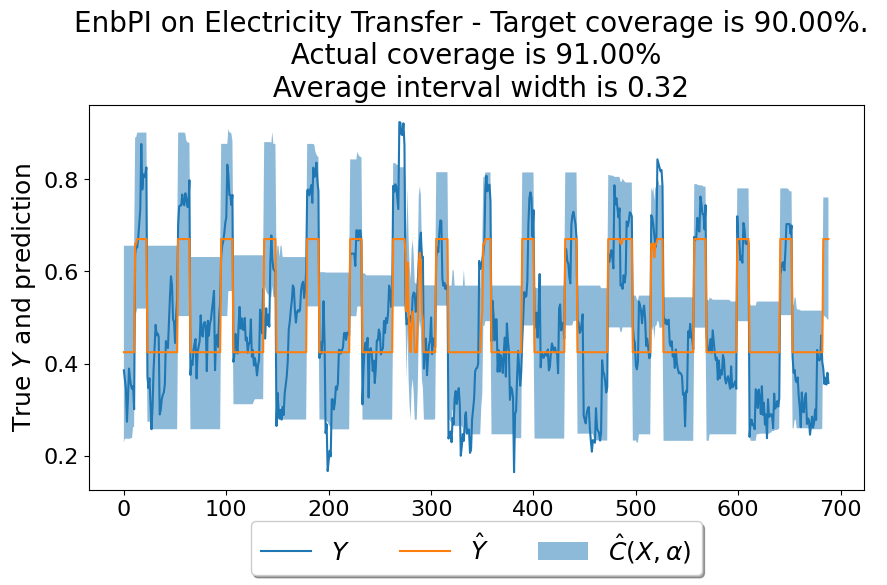

In [8]:
# Plot prediction intervals on test sample
Pred_ints = EnbPI_class_.PIs_Ensemble
Y_est = EnbPI_class_.Ensemble_pred_interval_centers
Y_predict = EnbPI_class_.Y_predict.numpy()
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(Y_predict, label=r'$Y$')
plt.plot(Y_est, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=3)
plt.xlabel('Test time index')
plt.ylabel('True $Y$ and prediction')
actual_cov = 100*results["coverage"].item()
actual_wid = results["width"].item()
plt.title(f'EnbPI on Electricity Transfer - Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')

### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.

In [9]:
# Define or get data
from utils import data 
import torch
dloader = data.real_data_loader()
X_full, Y_full = dloader.electric_dataset()
X_full = torch.from_numpy(X_full)
Y_full = torch.from_numpy(Y_full)
print('Full data shape')
print(X_full.shape, Y_full.shape)
# Use 80% for training
train_frac = 0.8
N = int(X_full.shape[0] * train_frac)
X_train, X_predict, Y_train, Y_predict = X_full[:N], X_full[N:], Y_full[:N], Y_full[N:]
# Use past_window # past residuals to predict the next one. If there are not so many residuals, one can decrease it
past_window = 300 
print(f'We will thus construct {len(Y_predict)} prediction intervals during test time')

Full data shape
torch.Size([3444, 4]) torch.Size([3444])
We will thus construct 689 prediction intervals during test time


In [10]:
# Initialize the SPCI class
from sklearn.ensemble import RandomForestRegressor
import SPCI_class as SPCI
fit_func = RandomForestRegressor(n_estimators=10, max_depth=1, criterion='squared_error',
                                bootstrap=False, n_jobs=-1, random_state=1103)
SPCI_class_  = SPCI.SPCI_and_EnbPI(X_train, X_predict, Y_train, Y_predict, fit_func=fit_func)
stride = 1
SPCI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.9096577167510986 secs.


In [11]:
use_SPCI = True
smallT = not use_SPCI
SPCI_class_.compute_PIs_Ensemble_online(
    alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI,
    quantile_regr=True, stride=stride)
results = SPCI_class_.get_results(alpha, 'my_data', 1)

Shape of slided residual lists is (689, 2755)
Width at test 0 is 0.18781034648418427
Width at test 34 is 0.26178300380706787
Width at test 68 is 0.19682446122169495
Width at test 102 is 0.30091717280447483
Width at test 136 is 0.2445538192987442
Width at test 170 is 0.20207757875323296
Width at test 204 is 0.19160358980298042
Width at test 238 is 0.18806225806474686
Width at test 272 is 0.24326497316360474
Width at test 306 is 0.19312450289726257
Width at test 340 is 0.26732419803738594
Width at test 374 is 0.19578681886196136
Width at test 408 is 0.20349938422441483
Width at test 442 is 0.22999392449855804
Width at test 476 is 0.19461718201637268
Width at test 510 is 0.20541110076010227
Width at test 544 is 0.18675591796636581
Width at test 578 is 0.1941327229142189
Width at test 612 is 0.2636170946061611
Width at test 646 is 0.266980417072773
Width at test 680 is 0.1832437366247177
Finish Computing 689 UNIQUE Prediction Intervals, took 164.8907811641693 secs.
Average Coverage is 0.93

Text(0.5, 1.0, 'SPCI on Electricity Transfer - Target coverage is 90.00%. \n Actual coverage is 93.32% \n Average interval width is 0.22')

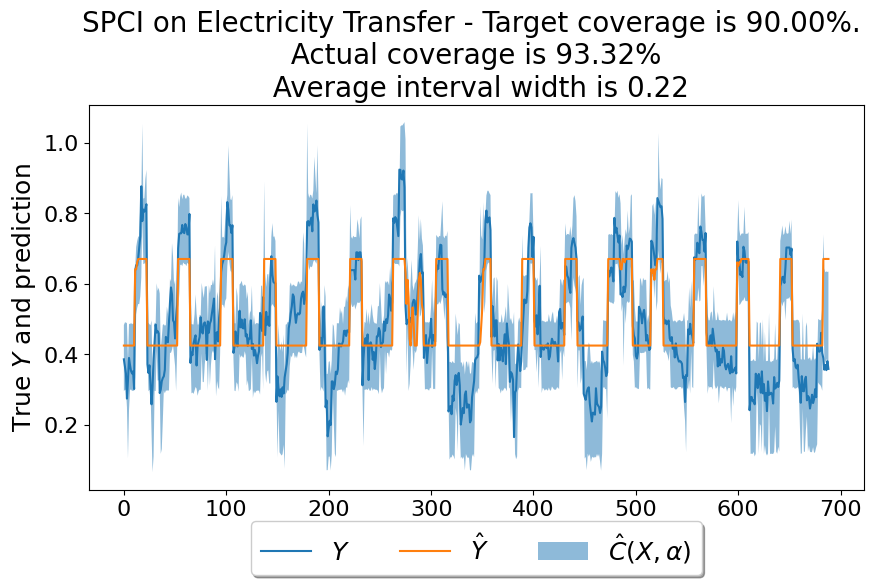

In [12]:
# Plot prediction intervals on test sample
Pred_ints = SPCI_class_.PIs_Ensemble
Y_est = SPCI_class_.Ensemble_pred_interval_centers
Y_predict = SPCI_class_.Y_predict.numpy()
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(Y_predict, label=r'$Y$')
plt.plot(Y_est, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=3)
plt.xlabel('Test time index')
plt.ylabel('True $Y$ and prediction')
actual_cov = 100*results["coverage"].item()
actual_wid = results["width"].item()
plt.title(f'SPCI on Electricity Transfer - Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')